> Experiments with cosine schedules for Classifier-free Guidance.   

In [ ]:
#| echo: false
import matplotlib.pyplot as plt

# Introduction

This notebook continues [previous experiments](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1/) on dynamically changing the Classifier-free Guidance parameter.  

To recap the earlier results: changing the guidance parameter $G$ improved the quality of generated images. More specifically:     

- **Normalizing** the guidance helped the image's syntax.  
- **Scheduling** the guidance improved the image details.  

The combination of the two often makes for even better generations.  

However, there is an open question about which dynamic changes are the best. The goal of this series is to, ideally, find changes that universally improve the quality of Diffusion images. 

# The `cf_guidance` library  

Guidance schedules and normalizers are now available in the [cf_guidance](https://pypi.org/project/cf-guidance/) library!   

We will use this library to generate images for a sweep of cosine schedules.  

In [ ]:
# helpers to create cosine schedules
from cf_guidance.schedules  import get_cos_sched

# normalizations for classifier-free guidance
from cf_guidance.transforms import GuidanceTfm, BaseNormGuidance, TNormGuidance

# Experiment Setup

The following section setups up the imports and helpers we need for the runs.  

First we import the needed python modules. 

## Imports

In [ ]:
import os
import math
import random
import warnings
from PIL import Image
from typing import List
from pathlib import Path
from types import SimpleNamespace
from fastcore.all import L

import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from tqdm.auto import tqdm 

# imports for diffusion models
import torch
from transformers import logging
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

# for clean outputs
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

# set the hardware device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

2022-11-21 19:06:22.967865: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Helper functions

The functions below help with:  

1. Generating text embeddings from a given prompt.  
2. Converting Diffusion latents to a PIL image.  
3. Plotting the images to visualize results.  

In [ ]:
def text_embeddings(prompts, maxlen=None):
    "Extracts text embeddings from the given `prompts`."
    maxlen = maxlen or tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0]


def image_from_latents(latents):
    "Scales diffusion `latents` and turns them into a PIL Image."
    
    # scale and decode the latents
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        data = vae.decode(latents).sample[0]

    # Create PIL image
    data = (data / 2 + 0.5).clamp(0, 1)
    data = data.cpu().permute(1, 2, 0).float().numpy()
    data = (data * 255).round().astype("uint8")
    image = Image.fromarray(data)
    return image
    
    
def show_image(image, scale=0.5):
    "Displays the given `image` resized based on `scale`."
    img = image.resize(((int)(image.width * scale), (int)(image.height * scale)))
    display(img)
    return img


def image_grid(images, rows = 1, width=256, height=256, title=None):
    "Display an array of images in a grid with the given number of `rows`"
    count = len(images)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    # Add some extra space for the caption/title since that can wrap
    h = (rows * height * px) + (rows * 30 * px)
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            ref.axis('off')
            if index > count - 1:
                continue
            img = images[index]
            txt = f'Frame: {index}'
            if title is not None:
                if isinstance(title, str):
                    txt = f'{title}: {index}'
                elif isinstance(title, List):
                    txt = title[index]
            # small change for bigger, more visible titles
            txt = '\n'.join(wrap(txt, width=70))
            ref.set_title(txt, fontsize='x-large')
            ref.imshow(img)
            ref.axis('off')
            

## Loading a Diffusion pipeline

We need to dynamically change the diffusion guidance parameter $G$. 

That means we need more control than what is available in the high-level HuggingFace APIs. To achieve this control, we load each piece of a Diffusion pipeline separately. Then, we can write our own image generation loop with full control over $G$.   

The `get_sd_pieces` function loads and returns the separate components of a Stable Diffusion pipeline.  

In [ ]:
def get_sd_pieces(model_name, dtype=torch.float32, better_vae='ema'):
    "Loads and returns the individual pieces in a Diffusion pipeline."
    
    # create the tokenizer and text encoder
    tokenizer = CLIPTokenizer.from_pretrained(
        model_name,
        subfolder="tokenizer",
        torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained(
        model_name,
        subfolder="text_encoder",
        torch_dtype=dtype).to(device)

    # we are using a VAE from stability that was trained for longer than the baseline 
    if better_vae:
        assert better_vae in ('ema', 'mse')
        vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{better_vae}", torch_dtype=dtype).to(device)
    else:
        vae = AutoencoderKL.from_pretrained(model_name, subfolder='vae', torch_dtype=dtype).to(device)
    
    # build the unet
    unet = UNet2DConditionModel.from_pretrained(
        model_name,
        subfolder="unet",
        torch_dtype=dtype).to(device)
    
    # enable unet attention slicing
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)
        
    # build the scheduler
    scheduler = LMSDiscreteScheduler.from_config(model_name, subfolder="scheduler")
    
    return (
        tokenizer,
        text_encoder,
        vae,
        unet,
        scheduler,
    )

### Picking a model

These runs use the `openjourney` model from [Prompt Hero](https://huggingface.co/prompthero/openjourney).  

:::: {.callout-important}  
`openjourney` was fine-tuned to create images in the style of [Midjourney v4](https://mezha.media/en/2022/11/11/midjourney-v4-is-an-incredible-new-version-of-the-ai-image-generator/).  

To trigger this style, we need to add the special keyword `"mdjrny-v4"` at the front of an input text prompt.  
::::

In [ ]:
# set the diffusion model
model_name = "prompthero/openjourney"

# other possible models
# model_name = "CompVis/stable-diffusion-v1-4"
# model_name = "runwayml/stable-diffusion-v1-5"

Next we use the function `get_sd_pieces` to load this model. The pieces are loaded in `float16` precision.

In [ ]:
# set the data type for the pipeline
dtype = torch.float16

# load the individual diffusion pieces
pieces = get_sd_pieces(model_name, dtype=dtype)
(tokenizer, text_encoder, vae, unet, scheduler) = pieces

## Text prompt for generations

We use the same input text prompt from the previous notebook:  

> "*a photograph of an astronaut riding a horse*"

But, we add the special prefix keyword `"mdjrny-v4"` to create Midjourney-style images.  

In [ ]:
# input text prompt for diffusion models
prompt = "mdjrny-v4 style a photograph of an astronaut riding a horse"

## Generating images

The images will be generated over $50$ diffusion steps. They will have a height and width size of `512 x 512` pixels. 

In [ ]:
# the number of diffusion steps
num_steps = 50

# generated image dimensions
width, height = 512, 512

### Creating a fixed starting point for diffusion

The code below creates an initial set of latent noise.  

The idea is for every generation to start from this shared, fixed noise. That way we can be sure that only our guidance changes are having an effect on the output image.

In [ ]:
# create the shared, initial latents
seed = 1024
torch.manual_seed(seed)
init_latents = torch.randn((1, unet.in_channels, height//8, width//8), dtype=unet.dtype, device=device)

### Image generation function

Below is the main image generation function: `generate`. It uses the Stable Diffusion components we loaded earlier.  

Note that this function is almost identical to the `StableDiffusionPipeline` from HuggingFace. The main difference is plugging in our Guidance Transform instead of doing the default Classifier-free Guidance update.  

In [ ]:
def generate(prompt, guide_tfm=None, width=width, height=height, steps=num_steps, **kwargs):
    # make sure we have a guidance transformation
    assert guide_tfm
    
    # prepare the text embeddings
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text]).type(unet.dtype)
    
    # start from the shared, initial latents
    latents = torch.clone(init_latents)
    scheduler.set_timesteps(steps)
    latents = latents * scheduler.init_noise_sigma
    
    # run the diffusion process
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        
        # call the guidance transform
        pred = guide_tfm(u, t, idx=i)
        
        # update the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
    # decode and return the final latents
    image = image_from_latents(latents)
    return image    

# Function to run the experiments

The `run` function below generates images for a given prompt.  

It takes an argument `guide_tfm` for the specific `GuidanceTfm` class that will guide the outputs.  \
The `schedules` argument has the set of schedules to sweep for $G$.  

In [ ]:
def run(prompt, schedules, guide_tfm=None, show_each=True, test_run=False):
    # store generated images and their title (the experiment name)
    images, titles = [], []
    
    assert guide_tfm
    print(f'Using Guidance Transform: {guide_tfm}')
    
    if test_run:
        print(f'Running a single schedule for testing.')
        schedules = schedules[:1]
        
    ns = len(schedules)
    # run all schedule experiments
    for i,s in enumerate(schedules):
        
        # parse out the title for the current run
        cur_title  = s['title']
        titles.append(cur_title)
        
        # create the guidance transformation 
        cur_sched = s['schedule']
        gtfm = guide_tfm({'g': cur_sched})
        
        print(f'Running experiment [{i+1} of {ns}]: {cur_title}...')
        img = generate(prompt, gtfm)
        images.append(img)
        
        # optionally plot the image
        if show_each:
            show_image(img, scale=1)

    print('Done.')
    return {
        'images': images,
        'titles': titles,
    }

# The Baseline: Guidance with a constant $G =7.5$

We need a good baseline to find out exactly how dynamic guidances affect the output images.  

Below we create the baseline Classifier-free Guidance with a static, constant update of $G = 7.5$.  

The code below seems like a lot of overhead, but it will be very helpful to sweep a variety of cosine schedules later on.  

In [ ]:
# create the baseline Classifier-free Guidance
baseline_run = {
    'max_val': [7.5],
}

# parameters we are sweeping
baselines_names = sorted(list(baseline_run))
baseline_scheds = L()

# step through each parameter
for idx,name in enumerate(baselines_names):
    # step through each of its values
    for idj,val in enumerate(baseline_run[name]):

        # create the baseline experimeent
        expt = {
            'param_name': name,
            'val': val,
            'schedule': [val for _ in range(num_steps)]
        }
        # for plotting
        expt['title'] = f'Param: "{name}", val={val}'
        
        # add to the running list of experiments
        baseline_scheds.append(expt)

Let's create the baseline image. The hope is that our guidance changes can then improve on it.  

Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 1]: Param: "max_val", val=7.5...


  0%|          | 0/50 [00:00<?, ?it/s]

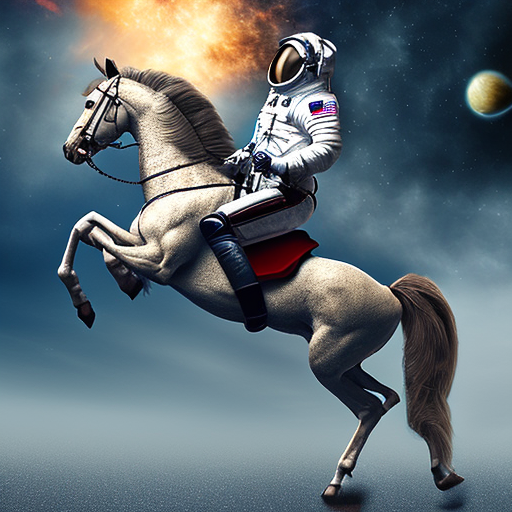

Done.


In [ ]:
basline_res = run(prompt, baseline_scheds, guide_tfm=GuidanceTfm, show_each=True)

Not bad for a starting point. Let's see if we can do better.  

# Trying to improve the baseline

We now use the [cf_guidance](https://github.com/enzokro/guidance_transforms) library to create a variety of Cosine schedules.  

From the previous notebook, we know that a regular Cosine schedule can improve image generations. The goal now is to figure out exactly what makes for a good Cosine schedule.  

This is a hard question to answer. We can start by trying incremental, minimum-pair changes to a baseline schedule. Then we check what effects, if any, our dynamic guidances have on the generated images.  

:::: {.callout-note}  
The recent trend in Diffusion variance schedules is to add noise in a slower, more gradual way. This change seems to improve both model training and inference generations.  

We will keep this in mind in future notebooks as we explore more schedules.  
::::

Once we have a sense of which schedules work (and which don't), we can explore the scheduling space in a better, more principled way.  

## Default schedule parameters

We start from the guidance schedule value from the previous notebook.  

Recall that there were three kinds of schedules:  

1. A static schedule with a constant $G$.  
2. A decreasing Cosine schedule.  
3. A Cosine schedule with some initial warm up steps.   

In [ ]:
# Default schedule parameters from the blog post
######################################
max_val           = 7.5   # guidance scaling value
min_val           = 1     # minimum guidance scaling
num_steps         = 50    # number of diffusion steps
num_warmup_steps  = 0     # number of warmup steps
warmup_init_val   = 0     # the intial warmup value
num_cycles        = 0.5   # number of cosine cycles
k_decay           = 1     # k-decay for cosine curve scaling 
######################################

To make sure our changes always reference this shared starting point, we can wrap these parameters in a dictionary.   

In [ ]:
DEFAULT_COS_PARAMS = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        num_cycles,
    'k_decay':           k_decay,
    'num_warmup_steps':  num_warmup_steps,
    'warmup_init_val':   warmup_init_val,
}

Then, every minimum-pair change will start from this shared dictionary and update a single parameter. The `cos_harness` below gives us an easy way of making these minimum-pair changes.  

In [ ]:
def cos_harness(new_params={}, cos_params=DEFAULT_COS_PARAMS):
    '''Creates cosine schedules with updated parameters in `new_params`'''
    
    # start from the given baseline `cos_params`
    cos_params = dict(cos_params)
    
    # update the schedule with any new parameters
    if new_params: cos_params.update(new_params)
    
    # return the new cosine schedule
    sched = get_cos_sched(**cos_params)
    return sched

In [ ]:
#| echo: false

def plot_schedules(scheds, rows = 1, width=256, height=256, titles=None):
    "Display an array of images in a nice grid, or single row"
    count = len(scheds)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    # Add some extra space for the caption/title since that can wrap
    h = (rows * height * px) + (rows * 30 * px)
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            if index > count - 1:
                ref.axis('off')
                continue
            sched = scheds[index]
            txt = f'Frame: {index}'
            if titles is not None:
                if isinstance(titles, str):
                    txt = f'{titles}: {index}'
                elif isinstance(titles, List) or isinstance(titles, L):
                    txt = titles[index]
            # small change for bigger, more visible titles
            txt = '\n'.join(wrap(txt, width=30))
            ref.set_title(txt, fontsize='x-large')
            ref.plot(sched)
            #ref.axis('off')
            ref.set_xlabel('Diffusion Timesteps')
            ref.set_ylabel('Guidance Parameter')
    fig.tight_layout()

Let's use the cosine harness to plot three test schedules, just to make sure things are working: 

- The baseline with no warmup.  
- Warmup for 5 steps.  
- Warmup for 10 steps.  

:::: {.callout-note}  
The schedule plotting function `plot_schedules` is available in the post's notebook.               
::::

Plotting sample cosine schedules...


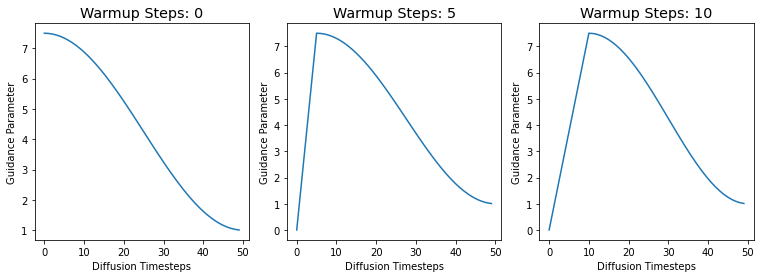

In [ ]:
# plot cosine schedules with different number of warmup steps
warmup_steps = (0, 5, 10)
warm_g = L( 
    {'sched': cos_harness({'num_warmup_steps': w}), 
     'title': f'Warmup Steps: {w}'}
    for w in warmup_steps
)

# plot the schedules
print('Plotting sample cosine schedules...')
plot_schedules(warm_g.itemgot('sched'), rows=1, titles=warm_g.itemgot('title'))

## Creating the Cosine experiments

Now we can create the different Cosine schedules that will be swept. 

In [ ]:
cos_param_sweep = {
    'num_warmup_steps': [5, 10, 15],
    'num_cycles':       [1, 1.5],
    'k_decay':          [0.8, 0.6],
    'max_val':          [10],
    'min_val':          [3],
}

param_names = sorted(list(cos_param_sweep))

cos_scheds = L()
for idx,name in enumerate(param_names):
    for idj,val in enumerate(cos_param_sweep[name]):

        # create the cosine experimeent
        expt = {
            'param_name': name,
            'val': val,
            'schedule': cos_harness({name: val})
        }
        # for plotting
        expt['title'] = f'Param: "{name}", val={val}'
        
        cos_scheds.append(expt)
    

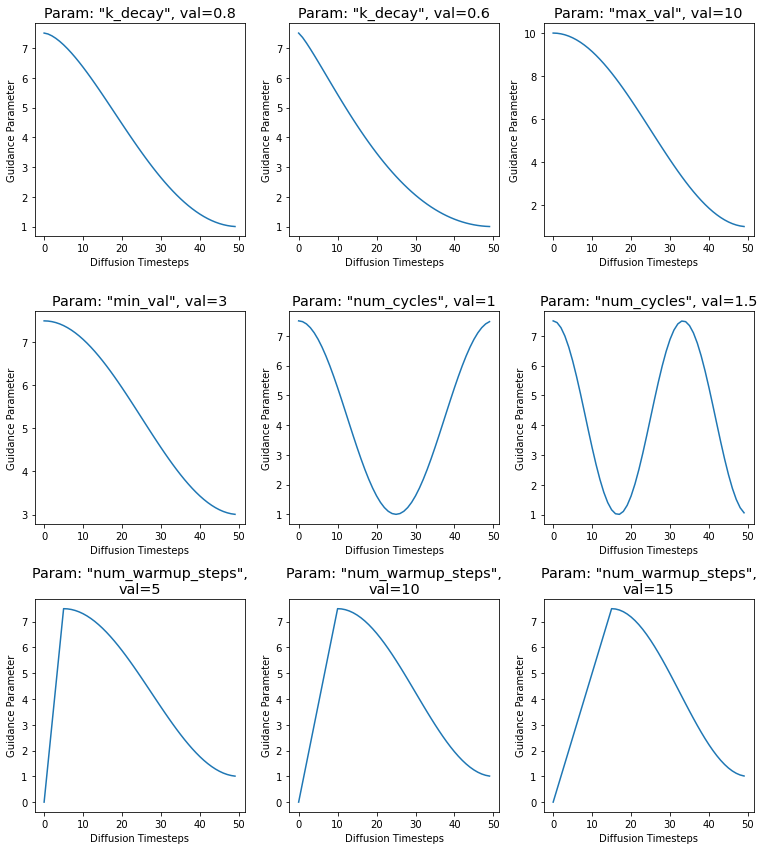

In [ ]:
plot_schedules(cos_scheds.itemgot('schedule'), rows=3, titles=cos_scheds.itemgot('title'))

## Running the cosine experiments

We use the `run` function from before to run all of the cosine experiments. 

In [ ]:
cos_res = run(prompt, cos_scheds, guide_tfm=GuidanceTfm, show_each=False)

Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 9]: Param: "k_decay", val=0.8...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 9]: Param: "k_decay", val=0.6...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [3 of 9]: Param: "max_val", val=10...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [4 of 9]: Param: "min_val", val=3...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [5 of 9]: Param: "num_cycles", val=1...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [6 of 9]: Param: "num_cycles", val=1.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [7 of 9]: Param: "num_warmup_steps", val=5...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [8 of 9]: Param: "num_warmup_steps", val=10...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [9 of 9]: Param: "num_warmup_steps", val=15...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


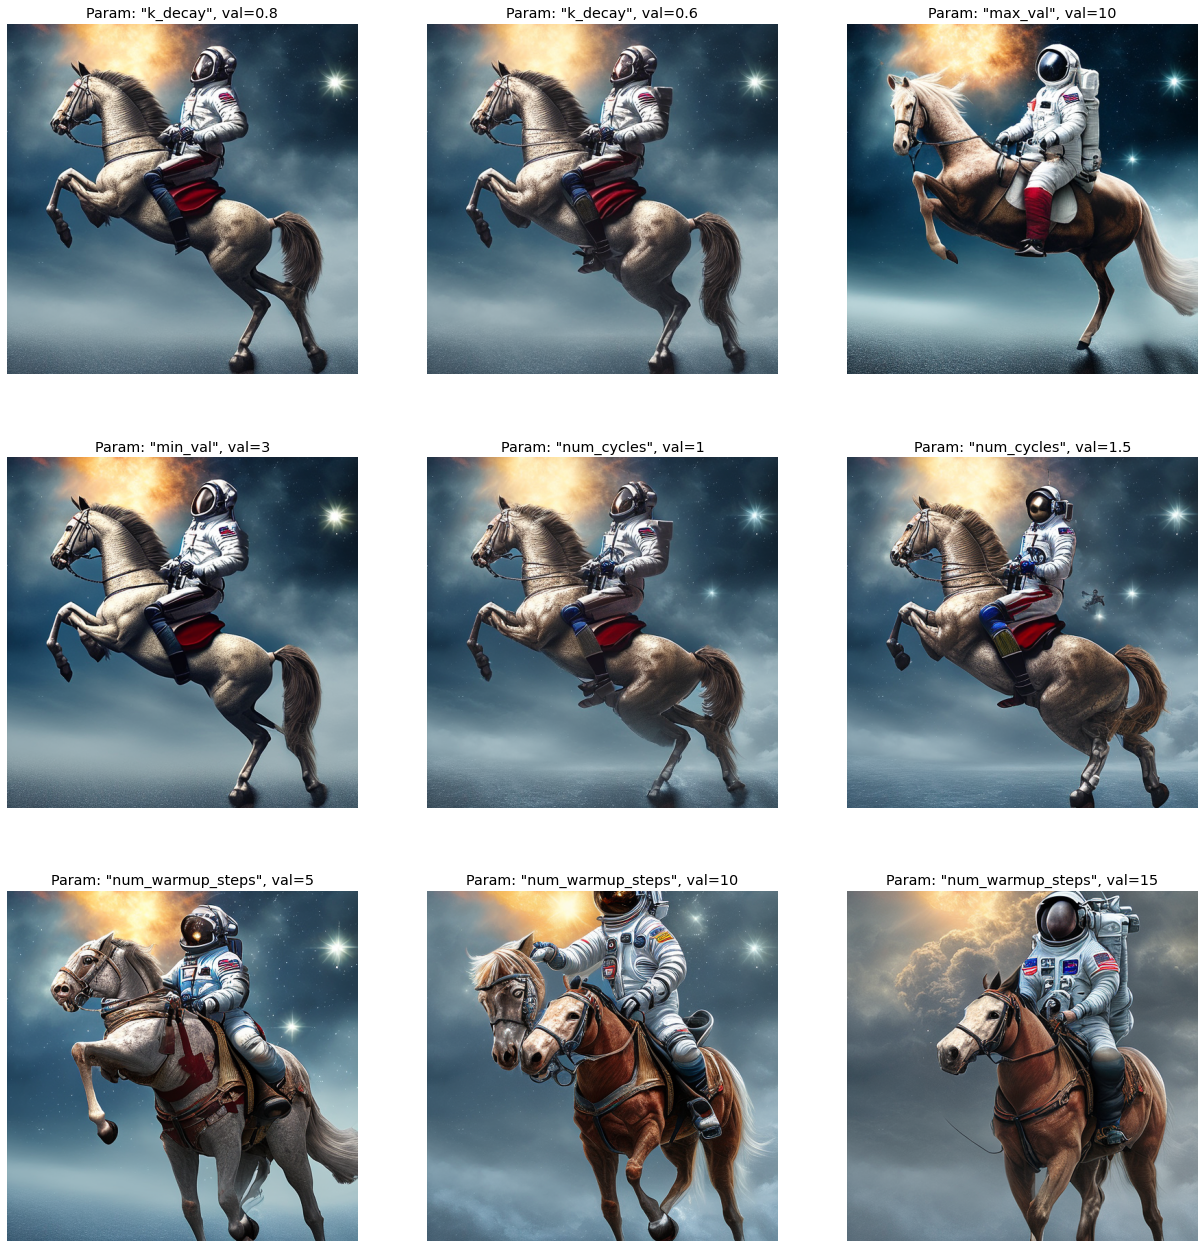

In [ ]:
#| echo: false
#| output: true
# display all images
image_grid(cos_res['images'], title=cos_res['titles'], rows=3, width=width, height=height)

# Results  

Going through the images, we can spot a few patterns.

Changing the minimum value of $G$ does not have a huge effect. However, changing the max value of $G$ to $10$ actively hurt the image.  

It seems that going through more cosine cycles improved the horse's anatomy. It now has two hind legs and its body looks more proportional.  

The number of warmup steps has a mixed effect. The lower value of $5$ and $10$ produce... interesting outputs with morphed horses. If it weren't for the floating horse head at 10 warmup steps, it would be a solid improvement. At $15$ warmup steps we get a lovely image with a nice, detailed background..  

## Analysis  

Certain Cosine schedules seem promising. They either increase the details of the astronaut or background, or they create more anatomically correct horses.  

In the rest of the series, we will explore the promising Cosine changes:  

- Setting a higher Guidance ceiling.  
- Allowing the Cosine to go through multiple cycles.  
- Warming up for a few steps.  

## Bringing in Normalizations

In the previous notebooks, we found that normalization can have a huge improvement on generated images. The next logical step is to add normalizations to our schedules to see if the gains compound. 

# Conclusion

This notebook used the `cf_guidance` library to run a set of Guidance experiments. We swept a variety of Cosine schedules and compared the results to a baseline generation.  

We showed that the guidance schedule has a big impact on the quality and syntax of generated images. We also found a set of Cosine schedules with the potential to improve generated images.  

In the next part of this series, we will combine cosine schedules with normalizations. 